##Downloading the Oxford-3T Pets dataset

In [ ]:
#importing the libraries
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

In [ ]:
#download the dataset
(train_data, test_data), ds_info = tfds.load('oxford_iiit_pet:3.*.*',
                                             with_info=True,
                                             split=['train', 'test'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteC4ZCZ3/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteC4ZCZ3/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


##Preprocessing of Data

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>)

In [ ]:
#infor
ds_info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

###Normalization & Loading

In [ ]:
#function for normalization
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32)/255.
  input_mask -= 1
  return input_image, input_mask


In [ ]:
#loadimages
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224))
  input_mask  = tf.image.resize(datapoint['segmentation_mask'], (224,224))

  input_image, input_mask = normalize(input_image,
                                      input_mask)
  return input_image, input_mask

In [ ]:
#trainlen and batch size
TRAIN_LENGTH = ds_info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000


In [ ]:
TRAIN_LENGTH

3680

In [ ]:
train_data = train_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<ParallelMapDataset shapes: ((224, 224, 3), (224, 224, 1)), types: (tf.float32, tf.float32)>,
 <ParallelMapDataset shapes: ((224, 224, 3), (224, 224, 1)), types: (tf.float32, tf.float32)>)

###Data Augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=54):
    super().__init__()
    self.augment_inputs = preprocessing.RandomFlip(mode="horizontal",
                                                   seed=seed)
    self.augment_labels = preprocessing.RandomFlip(mode="horizontal",
                                                   seed=seed)
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
#build the input pipeline
train_batches = (
    train_data
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
                 )

test_batches= test_data.batch(BATCH_SIZE)

NameError: ignored

##Visualize the data

In [ ]:
import matplotlib.pyplot as plt
def display(display_list):
  plt.figure(figsize=(15,15))

  title=['Input_Image', 'True_Mask', 'Predicted_Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

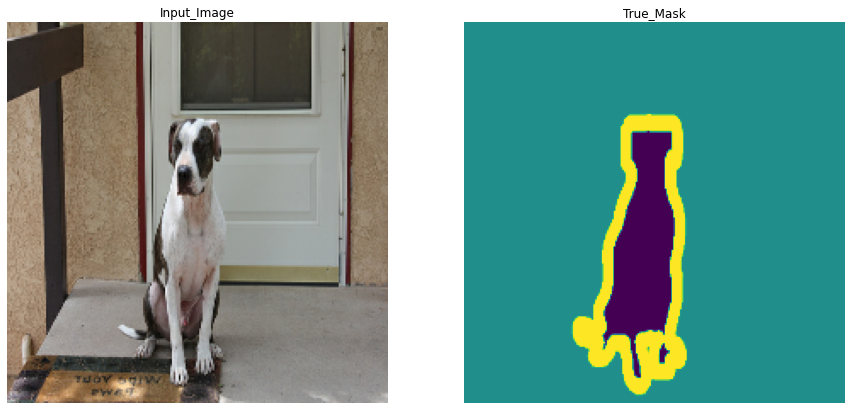

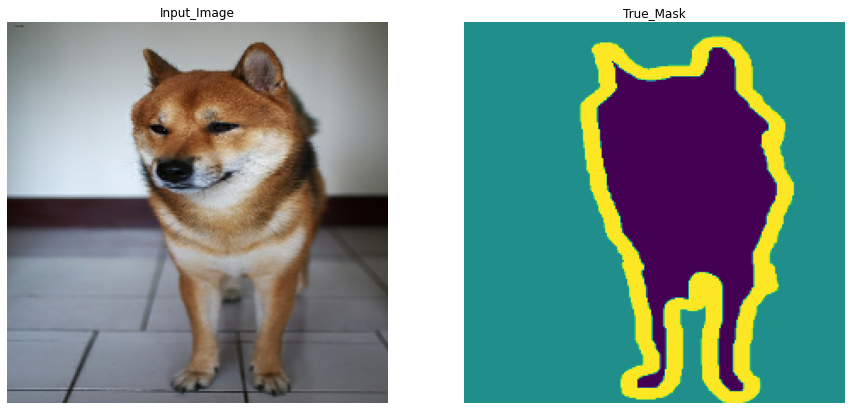

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[1], masks[1]
  display ([sample_image, sample_mask])

##Defining the Model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                               input_shape=[224,224,3])

layer_names = [
               'block_1_expand_relu',
               'block_3_expand_relu',
               'block_6_expand_relu',
               'block_13_expand_relu',
               'block_16_project'
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

#Feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
#Decoder/upsampler
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
up_stack =[
           pix2pix.upsample(512, 3),
           pix2pix.upsample(256, 3),
           pix2pix.upsample(128, 3),
           pix2pix.upsample(64, 3)
]

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ccojeflz
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ccojeflz
  Created wheel for tensorflow-examples: filename=tensorflow_examples-130722981aee8ed4f1def8edd43bd8a4400ff226_-py3-none-any.whl size=271412 sha256=126ed8019afedc8749ca9377722598b17b9435bd9812b7cfd007f112d7f0e736
  Stored in directory: /tmp/pip-ephem-wheel-cache-mi1yguv9/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
#unet_model
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224,224,3])
  #downsampling
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  #upsampling
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  #last layer of model
  last = tf.keras.layers.Conv2DTranspose(
      filters = output_channels, kernel_size=3, strides=2,
      padding='same'
  )
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


##Train the model

In [ ]:
output_classes=3
model = unet_model(output_channels=output_classes)
model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

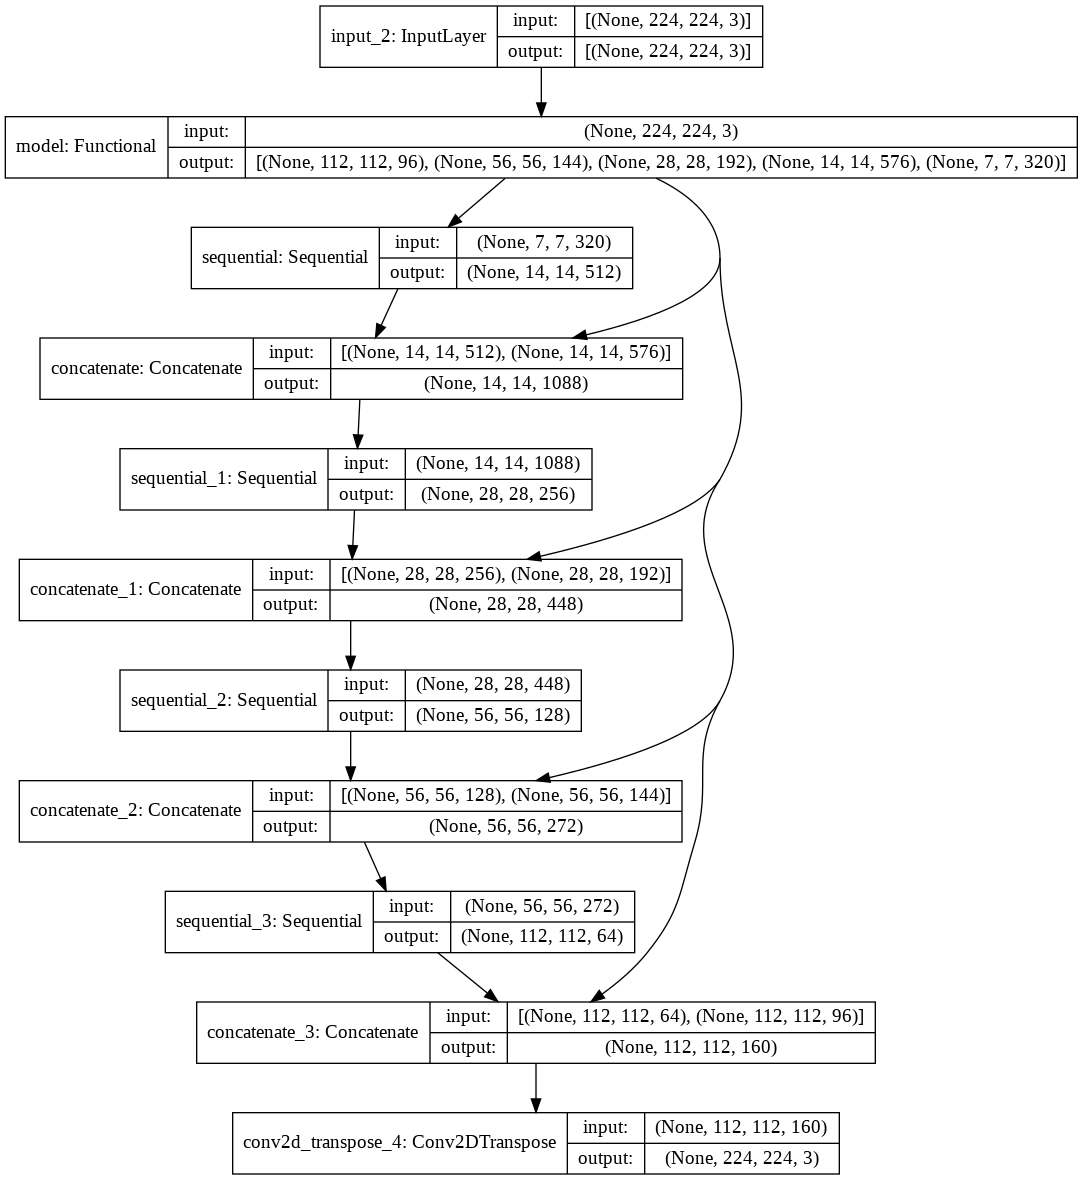

In [ ]:
# show the model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
#fuctions for predictions
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

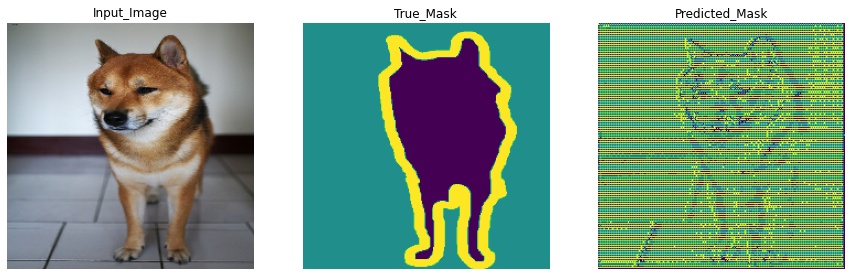

In [ ]:
#predictions before training
show_predictions()

In [ ]:
#Call back
from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_prediction()
    print('\nsample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
model_history = model.fit(train_batches,
                          epochs=10,
                          validation_data= test_batches,
                          validation_steps=int(0.15 * len(test_batches)),
                          steps_per_epoch=115,
                          )

Epoch 1/10
115/115 [==============================] - 58s 425ms/step - loss: 0.3988 - accuracy: 0.8413 - val_loss: 0.3253 - val_accuracy: 0.8751
Epoch 2/10
115/115 [==============================] - 49s 423ms/step - loss: 0.2633 - accuracy: 0.8919 - val_loss: 0.2600 - val_accuracy: 0.8959
Epoch 3/10
115/115 [==============================] - 49s 426ms/step - loss: 0.2511 - accuracy: 0.8955 - val_loss: 0.2543 - val_accuracy: 0.8974
Epoch 4/10
115/115 [==============================] - 49s 423ms/step - loss: 0.2405 - accuracy: 0.8991 - val_loss: 0.2511 - val_accuracy: 0.8986
Epoch 5/10
115/115 [==============================] - 49s 423ms/step - loss: 0.2340 - accuracy: 0.9015 - val_loss: 0.2475 - val_accuracy: 0.8995
Epoch 6/10
115/115 [==============================] - 49s 425ms/step - loss: 0.2264 - accuracy: 0.9039 - val_loss: 0.2407 - val_accuracy: 0.9022
Epoch 7/10
115/115 [==============================] - 49s 423ms/step - loss: 0.2277 - accuracy: 0.9035 - val_loss: 0.2436 - val_ac

In [ ]:
results=model.evaluate(test_batches)

115/115 [==============================] - 23s 194ms/step - loss: 0.2409 - accuracy: 0.9015


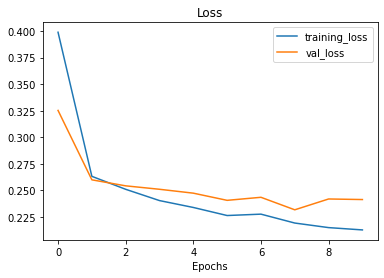

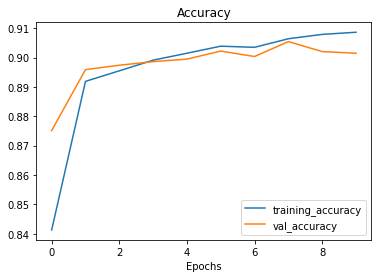

In [ ]:
plot_loss_curves(model_history)

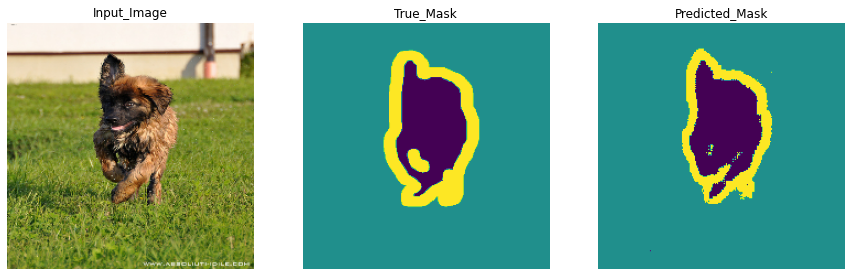

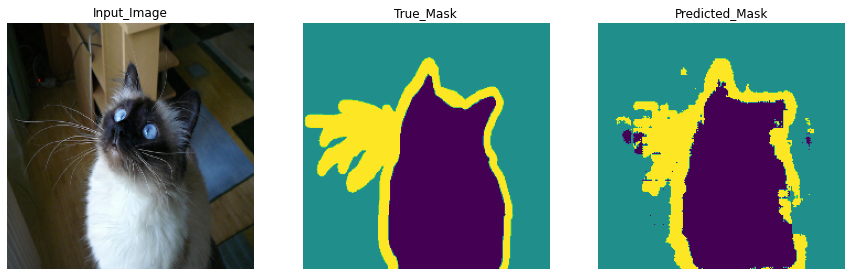

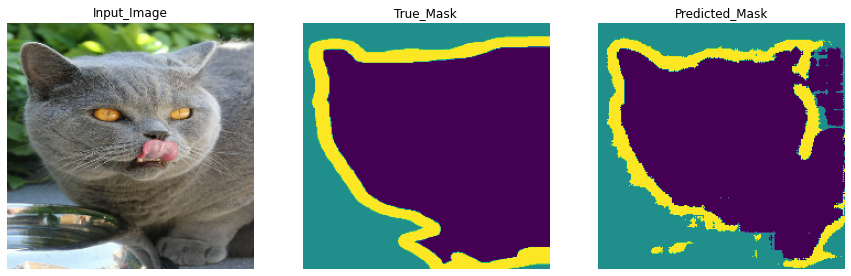

In [ ]:
show_predictions(test_batches, 3)

In [ ]:
img= plt.imread("/content/catanddog.jfif")

In [ ]:
img=tf.image.resize(img, (224,224))
img= tf.cast(img, tf.float32)
img=img/255.
img.shape

TensorShape([224, 224, 3])

In [ ]:
def pred(img):
  pred_mask=model.predict(tf.expand_dims(img, axis=0))
  display([img,  create_mask(pred_mask)])

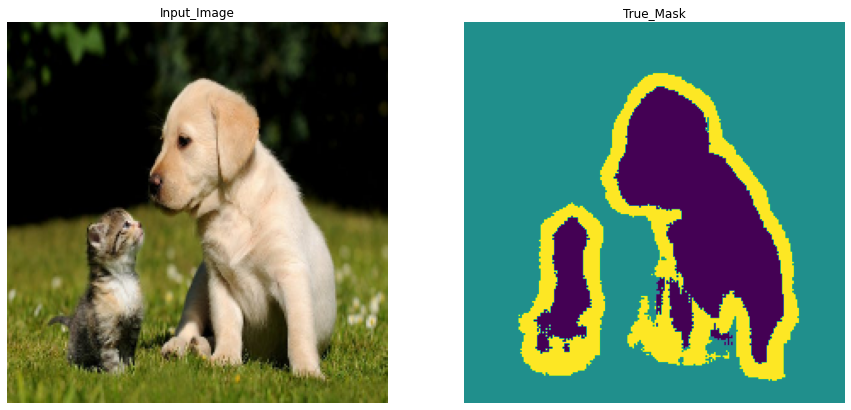

In [ ]:
pred(img)